# Whitening with non-negative gains

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import frame_whitening as fw
import frame_whitening.plot as fwplt
import frame_whitening.simulation as sim

## Schematic

Two frames for three different data covariances.

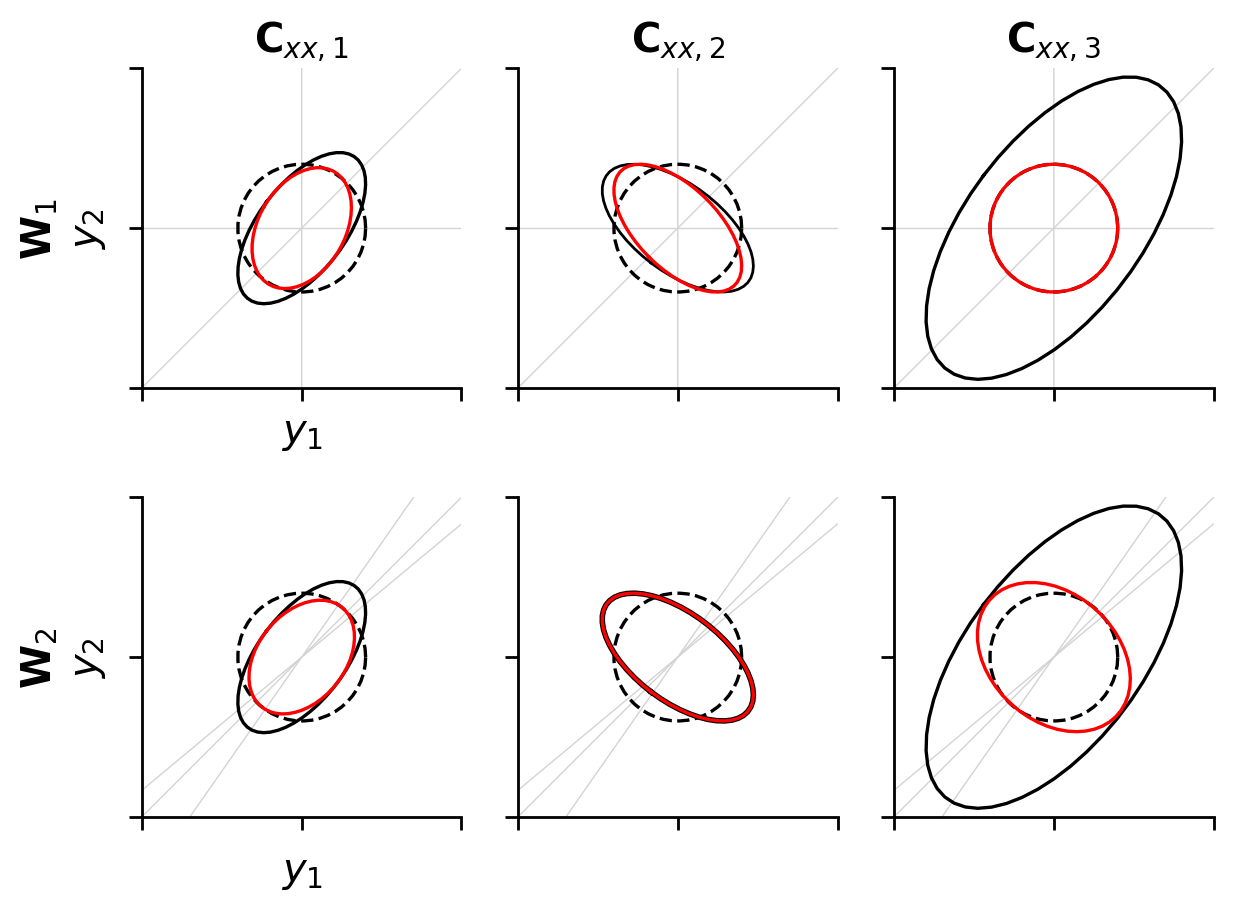

In [44]:
I = np.eye(2)

Q = fw.rot2(np.pi/2)
sigma_x = 1
sigma_y = 1.4
sigma_xy = 0.7
Cxx1 = np.array([[sigma_x, sigma_xy], [sigma_xy, sigma_y]])

Cxx  = [Cxx1, Q@Cxx1@Q.T, Cxx1*4]


W1 = fw.normalize_frame(np.array([[0+.00001, 1, 1],[1, 1, 0]]))

W2 = np.array([[1, .7, 1.2], [1, 1, 1]])
W2 = fw.normalize_frame(W2)

W = (W1, W2)

def get_m(W, g):
    return np.linalg.inv(I + W @ np.diag(g) @ W.T)

def whiten(Cxx, W, clamp):
    Lxx = np.linalg.cholesky(Cxx)
    g, g_all, errors, _ = sim.simulate([Lxx], W, 0, 10000, 1E-2, None, online=False, clamp=clamp)
    g = g.squeeze()
    M = get_m(W, g)
    return M @ Cxx @ M.T, g_all, errors

def plot_frame_axes2d(W, ax, colors=None, lim=5):
    if colors is None:
        colors = ["k"] * W.shape[1]
    else:
        assert len(colors) == W.shape[1]

    x = np.linspace(-lim, lim, 10)
    for i in range(W.shape[1]):
        ax.plot(x, (W[1, i] / W[0, i]) * x,  "-", lw=.5, color="lightgrey", zorder=-1)
   
with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(2, 3, sharey="all", sharex="all", dpi=200)
    fwplt.plot_ellipse(I, n_pts=50, ax=ax[0,0], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[0], n_pts=50, ax=ax[0,0], color="k")
    fwplt.plot_ellipse(whiten(Cxx[0], W[0], True)[0], n_pts=50, ax=ax[0,0], color="r")
    plot_frame_axes2d(W[0], ax[0,0])

    fwplt.plot_ellipse(I, n_pts=50, ax=ax[0,1], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[1], n_pts=50, ax=ax[0,1], color="k", lw=1)
    fwplt.plot_ellipse(whiten(Cxx[1], W[0], True)[0], n_pts=50, ax=ax[0,1], color="r")
    plot_frame_axes2d(W[0], ax[0,1])

    fwplt.plot_ellipse(I, n_pts=50, ax=ax[0,2], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[2], n_pts=50, ax=ax[0,2], color="k")
    fwplt.plot_ellipse(whiten(Cxx[2], W[0], True)[0], n_pts=50, ax=ax[0,2], color="r")
    plot_frame_axes2d(W[0], ax[0,2])

    fwplt.plot_ellipse(I, n_pts=50, ax=ax[1,0], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[0], n_pts=50, ax=ax[1,0], color="k")
    fwplt.plot_ellipse(whiten(Cxx[0], W[1], True)[0], n_pts=50, ax=ax[1,0], color="r")
    plot_frame_axes2d(W[1], ax[1,0])

    fwplt.plot_ellipse(I, n_pts=50, ax=ax[1,1], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[1], n_pts=50, ax=ax[1,1], color="k", lw=2)
    fwplt.plot_ellipse(whiten(Cxx[1], W[1], True)[0], n_pts=50, ax=ax[1,1], color="r")
    plot_frame_axes2d(W[1], ax[1,1])

    fwplt.plot_ellipse(I, n_pts=50, ax=ax[1,2], color="k", linestyle="--")
    fwplt.plot_ellipse(Cxx[2], n_pts=50, ax=ax[1,2], color="k")
    fwplt.plot_ellipse(whiten(Cxx[2], W[1], True)[0], n_pts=50, ax=ax[1,2], color="r")
    plot_frame_axes2d(W[1], ax[1,2])

    ax[0,0].axis("square")
    ax[0,1].axis("square")
    ax[1,0].axis("square")
    ax[1,1].axis("square")
    ax[0,2].axis("square")
    ax[1,2].axis("square")

    ax[0,0].set(xlim=(-5, 5), ylim=(-5, 5), yticks=(-5, 0, 5), xticks=(-5, 0, 5),
    xticklabels=[], yticklabels=[], ylabel=r"${\bf W}_1$" "\n" r"$y_2$", 
    title=r"${\bf C}_{xx,1}$", xlabel=r"$y_1$")
    ax[1,0].set(ylabel=r"${\bf W}_2$" "\n" r"$y_2$", xlabel=r"$y_1$")
    ax[0,1].set(title=r"${\bf C}_{xx,2}$")
    ax[0,2].set(title=r"${\bf C}_{xx,3}$")
    fig.tight_layout()
    sns.despine()

## Dynamics

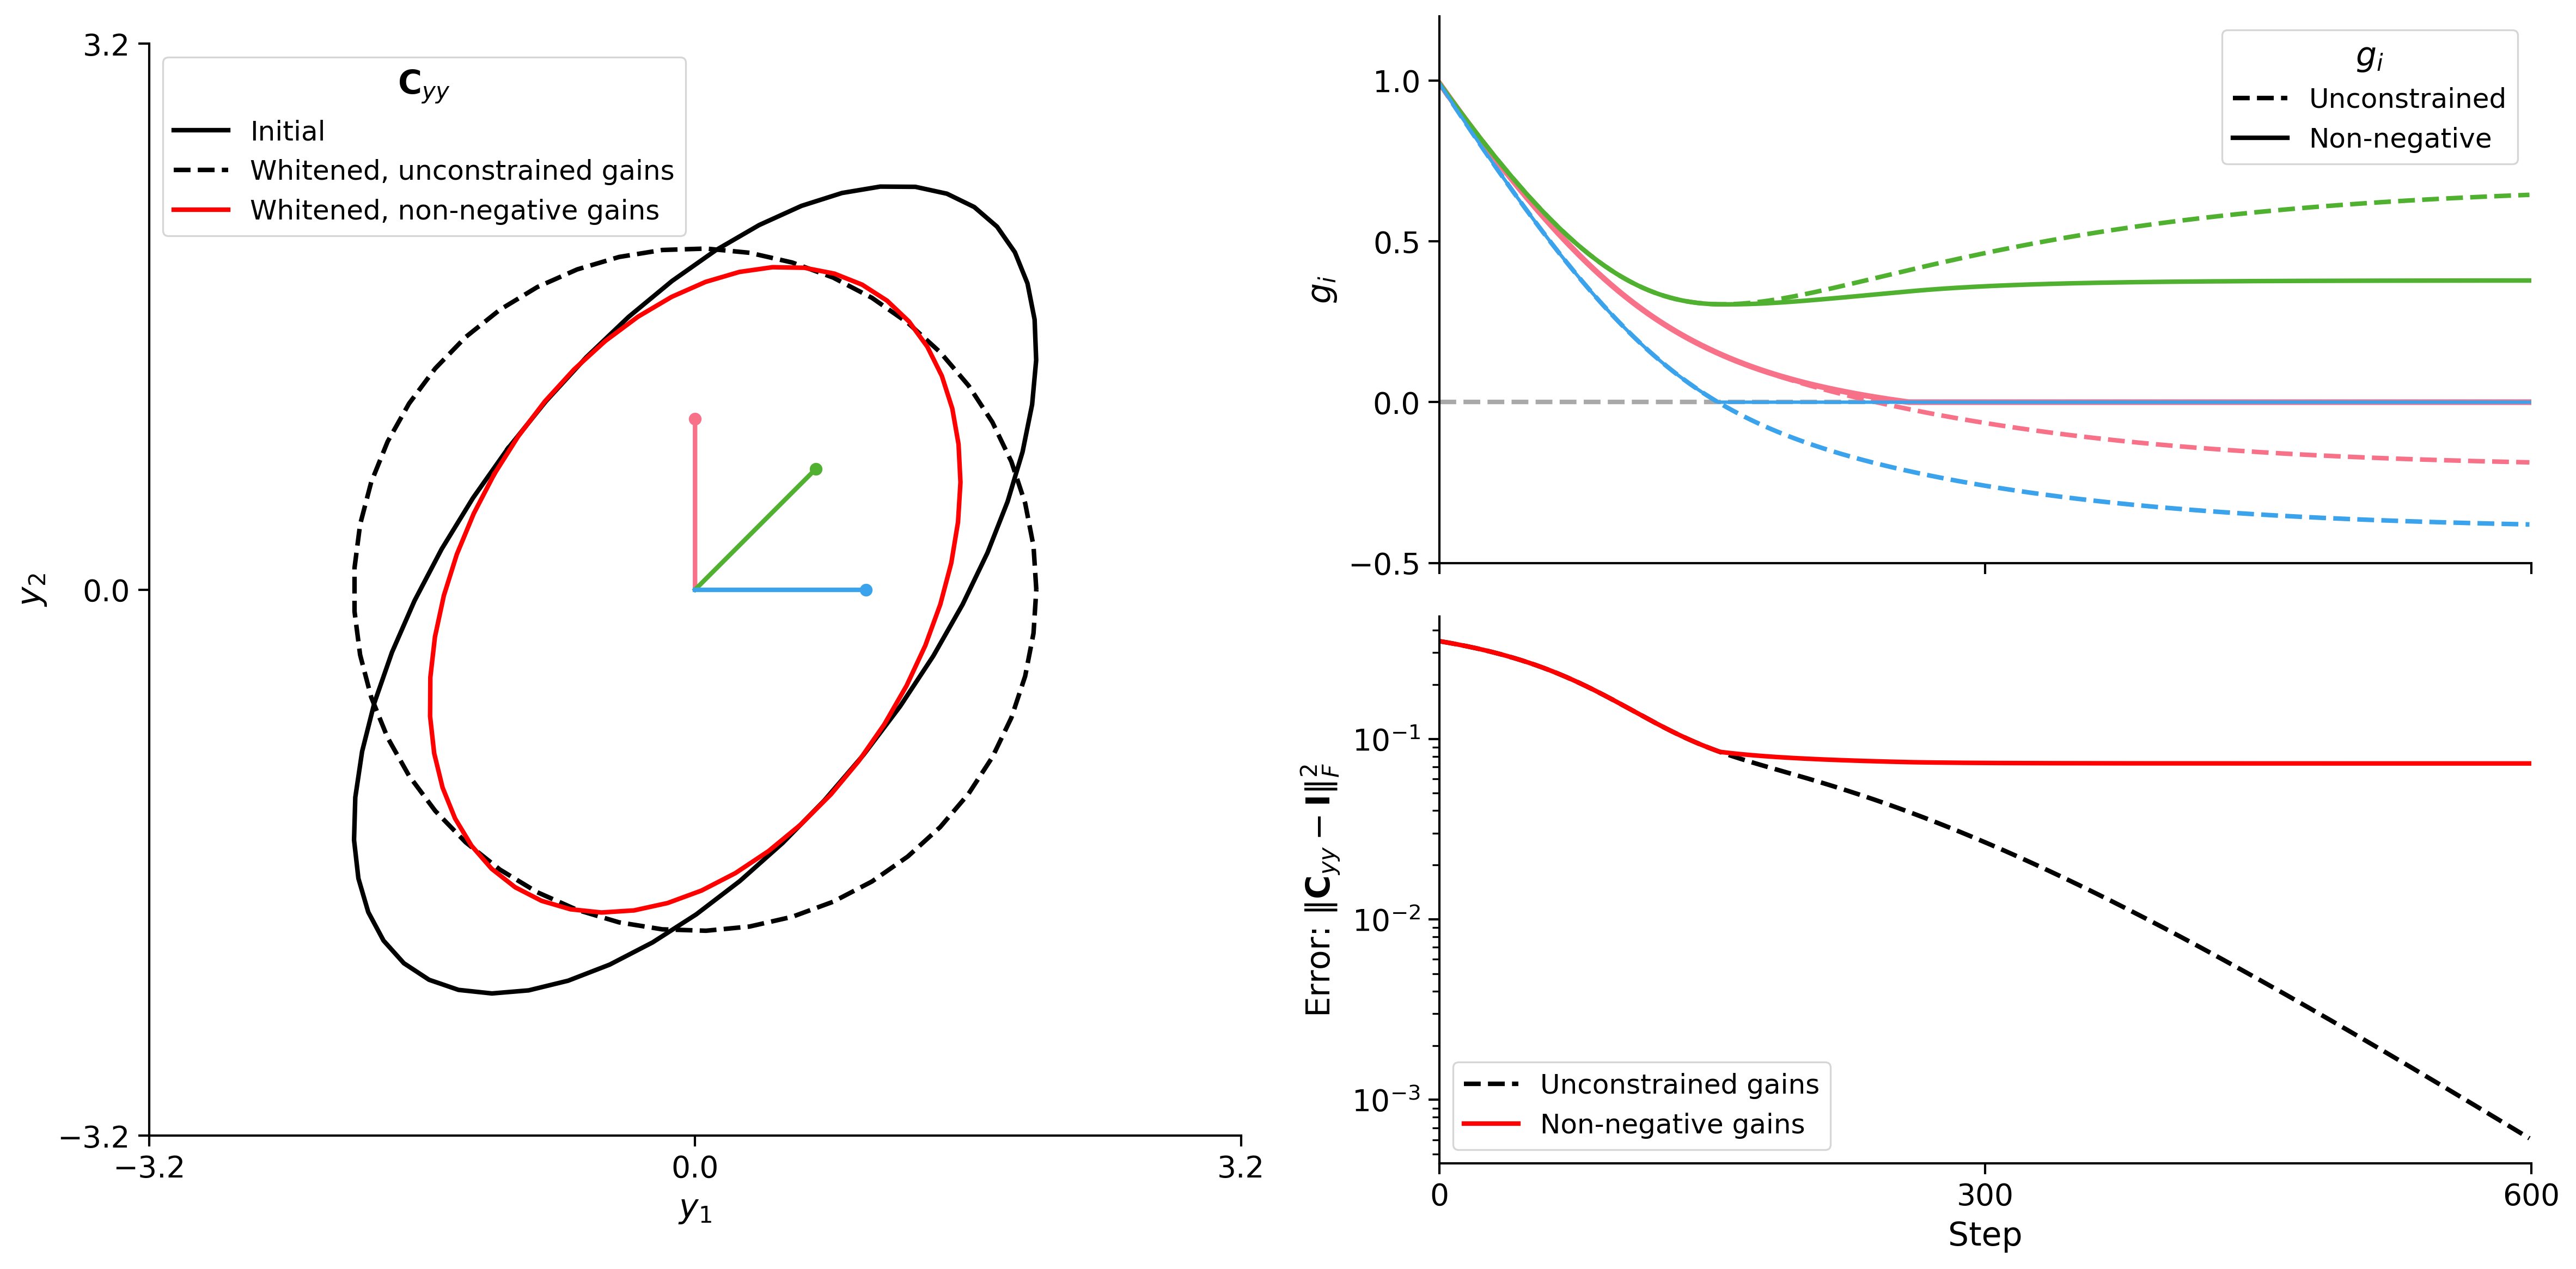

In [132]:
with sns.plotting_context("paper", font_scale=1.5):
    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(16, 8), sharex="col", dpi=300)
    gs = axs[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axs[0:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[0:, 0])

    Cww, g_all, errors = whiten(Cxx[0], W[0], False)
    Cww_clamped, g_all_clamped, errors_clamped = whiten(Cxx[0], W[0], True)

    lw = 2
    fwplt.plot_ellipse(Cxx[0], n_pts=50, ax=axbig, c="k", lw=2, label=r"Initial")
    fwplt.plot_ellipse(I, n_pts=50, ax=axbig, c="k", ls="--", lw=lw, label=r"Whitened, unconstrained gains")
    fwplt.plot_ellipse(Cww_clamped, n_pts=50, ax=axbig, c="r", lw=lw, label=r"Whitened, non-negative gains")
    # fwplt.plot_ellipse(Cww, n_pts=50, ax=axbig, c="purple", lw=lw)
    axbig.legend(loc="upper left", title=r"${\bf C}_{yy}$", fontsize=12)

    cols = sns.color_palette("husl", 3)

    axbig.axis("square")
    axlim = 3.2
    x = np.linspace(-axlim, axlim, 21)
    for i, w in enumerate(W[0].T):
        # axbig.plot(x, w[0]/(w[1]+1E-6)*x, "-", color=cols[i], lw=2, zorder=-1)
        axbig.plot((0, w[0]), (0, w[1]), "-", color=cols[i], lw=2, zorder=-1)
        axbig.scatter(w[0], w[1], color=cols[i], zorder=-1)

    axbig.set(xlim=(-axlim, axlim), ylim=(-axlim, axlim), 
    yticks=(-axlim, 0, axlim), xticks=(-axlim, 0, axlim), xlabel=r"$y_1$", ylabel=r"$y_2$")

    n_pts = 600
    # dummy plot to get the legend
    axs[0, 1].plot(0, 0, "--k", label="Unconstrained", lw=2)
    axs[0, 1].plot(0, 0, "-k", label="Non-negative", lw=2)
    axs[0, 1].set(yticks=(-.5, 0, .5, 1))

    for i in range(3):
        axs[0, 1].plot(g_all[:n_pts, i], color=cols[i], lw=2, ls="--")

    axs[0, 1].plot(g_all_clamped[:n_pts, 0], color=cols[0], lw=2.5)
    axs[0, 1].plot(g_all_clamped[:n_pts, 1], color=cols[1], lw=2)
    axs[0, 1].plot(g_all_clamped[:n_pts, 2], color=cols[2], lw=1.5)
    axs[0, 1].hlines(0, 0, n_pts, ls="--", lw=2, color="darkgrey", zorder=-1)
    axs[0, 1].set(xlim=(0, n_pts), ylabel=r"$g_i$", ylim=(-.5, 1.2))
    axs[0, 1].legend(loc="upper right", title=r"$g_i$", fontsize=12)

    axs[1, 1].plot(errors[:n_pts], "--k", label="Unconstrained gains", lw=2)
    axs[1, 1].plot(errors_clamped[:n_pts], "r", label="Non-negative gains", lw=2)
    axs[1, 1].set(yscale="log", xlabel="Step", ylabel=r"Error: $\Vert {\bf C}_{yy} - {\bf I}\Vert^2_F$",
    xticks=(0, n_pts//2, n_pts), 
    )
    axs[1, 1].legend(loc="lower left", fontsize=12)

    fig.tight_layout()
    sns.despine()

In [111]:
W[0]

array([[1.00000000e-05, 7.07106781e-01, 1.00000000e+00],
       [1.00000000e+00, 7.07106781e-01, 0.00000000e+00]])